![quotes](https://i.pinimg.com/originals/da/01/0e/da010e34fc7de98a3261e52ad1c11511.jpg)

# Loading Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2, VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Image Augmentation

In [2]:
data_generator = ImageDataGenerator(rescale=1.0/255.0, validation_split = 0.25)
#valid_data_generator = ImageDataGenerator(rescale=1.0/255.0)

In [3]:
train_generator = data_generator.flow_from_directory(directory= '../input/cell-images-for-detecting-malaria/cell_images/cell_images' ,             
                                                     target_size=(128, 128),
                                                     class_mode='binary',
                                                     subset='training',
                                                           shuffle=True,
                                                     batch_size=16
                                 )

valid_generator = data_generator.flow_from_directory(directory= '../input/cell-images-for-detecting-malaria/cell_images/cell_images',             
                                                     target_size=(128, 128),
                                                     class_mode='binary',
                                                           shuffle = True,
                                                     subset='validation',
                                                     batch_size=16,
                                                    
                                                     )


classes = ['Parasitized', 'Uninfected']

Found 20670 images belonging to 2 classes.
Found 6888 images belonging to 2 classes.


# Displaying The Images

In [4]:
sample_training_images, train_label = next(train_generator)

In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout() 
    plt.show()

Random Display of Cell images


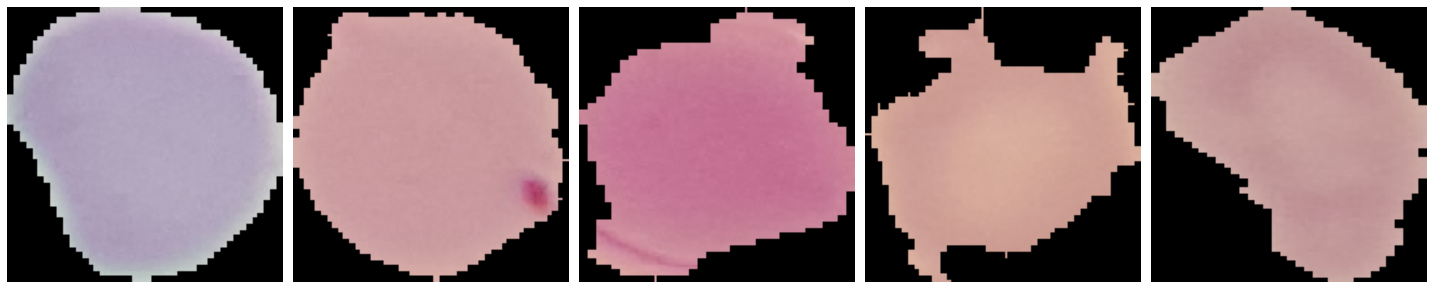

In [6]:
print('Random Display of Cell images')
plotImages(sample_training_images[:5])


# MobileNet Model Developement

In [7]:
model = Sequential()
model.add(MobileNetV2(include_top=False, pooling='avg', weights='imagenet', input_shape=(128, 128, 3), classes=2))

model.add(Dense(1, activation='sigmoid'))
model.layers[0].trainable = False
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [9]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs=20,
                              validation_steps = len(valid_generator),
                              validation_data=valid_generator,
                              callbacks = [early_stop]
                              )

Epoch 1/20
1292/1292 [==============================] - 62s 48ms/step - loss: 0.2532 - accuracy: 0.9001 - val_loss: 0.1915 - val_accuracy: 0.9309
Epoch 2/20
1292/1292 [==============================] - 46s 35ms/step - loss: 0.1913 - accuracy: 0.9299 - val_loss: 0.1913 - val_accuracy: 0.9281
Epoch 3/20
1292/1292 [==============================] - 47s 37ms/step - loss: 0.1769 - accuracy: 0.9371 - val_loss: 0.1911 - val_accuracy: 0.9299
Epoch 4/20
1292/1292 [==============================] - 45s 35ms/step - loss: 0.1691 - accuracy: 0.9402 - val_loss: 0.1843 - val_accuracy: 0.9310
Epoch 5/20
1292/1292 [==============================] - 46s 36ms/step - loss: 0.1644 - accuracy: 0.9417 - val_loss: 0.1726 - val_accuracy: 0.9389
Epoch 6/20
1292/1292 [==============================] - 45s 35ms/step - loss: 0.1633 - accuracy: 0.9418 - val_loss: 0.1833 - val_accuracy: 0.9344
Epoch 7/20
1292/1292 [==============================] - 45s 35ms/step - loss: 0.1589 - accuracy: 0.9432 - val_loss: 0.1802 -

In [10]:
model_name = 'malaria_predsmodel.h5'
model.save_weights(model_name)

# Model metrics plot

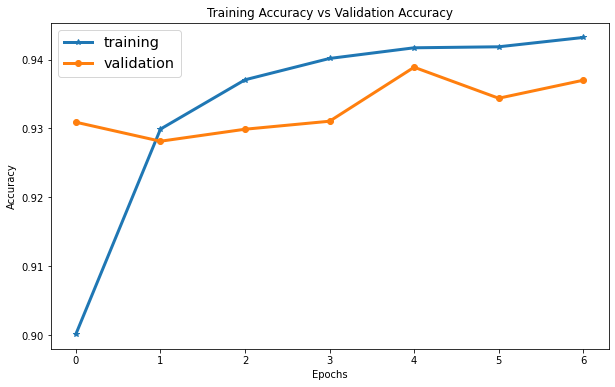

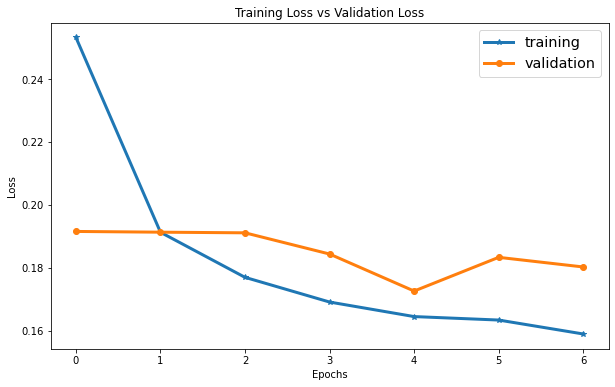

In [11]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize = 'x-large')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.show()
visualize_training(history)

# Predictions

In [12]:
preds = model.predict_generator(valid_generator,steps=15)
preds[0:5]

array([[0.99412894],
       [0.9961467 ],
       [0.98186433],
       [0.91295284],
       [0.00439809]], dtype=float32)

In [13]:
label = valid_generator.classes
pred= model.predict(valid_generator)

predicted_class_indices=np.argmax(pred,axis=1)

labels = (valid_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print (labels)
print (predictions)

[0 0 0 ... 0 0 0]
{'Parasitized': 0, 'Uninfected': 1}
['Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 

# Random Image Prediction

In [14]:
image_path = '../input/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'
image = tf.keras.preprocessing.image.load_img(image_path)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
preds1 = model.predict_classes(input_arr)


In [15]:
preds1

array([[0]], dtype=int32)

**So our model correctly predicts the Parasitized cell**

In [16]:
image_path = '../input/cell-images-for-detecting-malaria/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_128.png'
image = tf.keras.preprocessing.image.load_img(image_path)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
pred_uninfected = model.predict_classes(input_arr)

In [17]:
pred_uninfected

array([[0]], dtype=int32)

# Confusion Matrix And Classification Report

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

rc = roc_curve(predicted_class_indices,label)
cf_matrix = confusion_matrix(predicted_class_indices,label)
cf_report = classification_report(predicted_class_indices,label)
print('Confusion matrix report of the model : \n{}'.format(cf_matrix))

Confusion matrix report of the model : 
[[3444 3444]
 [   0    0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
print('Classification report of the model : \n{}'.format(cf_report))

Classification report of the model : 
              precision    recall  f1-score   support

           0       1.00      0.50      0.67      6888
           1       0.00      0.00      0.00         0

    accuracy                           0.50      6888
   macro avg       0.50      0.25      0.33      6888
weighted avg       1.00      0.50      0.67      6888



In [20]:
print('ROC metrics estimates : \n{}'.format(rc))

ROC metrics estimates : 
(array([0. , 0.5, 1. ]), array([nan, nan, nan]), array([2, 1, 0], dtype=int32))


In [21]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted,0,All
Actual,,
0,3444,3444
1,3444,3444
All,6888,6888


# VGG-19

In [22]:
vgg_model = Sequential()
vgg_model.add(VGG19(include_top=False, pooling='avg', weights='imagenet', input_shape=(128, 128, 3), classes=2))
vgg_model.add(Flatten())
vgg_model.add(Dense(64,activation='relu'))
vgg_model.add(Dense(1,activation = 'sigmoid'))

vgg_model.layers[0].trainable = False
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vgg_model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 512)               20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 20,057,281
Trainable params: 32,897
Non-trainable params: 20,024,384
_________________________________________________________________


In [23]:
vgg_history = vgg_model.fit_generator(train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs=20,
                              validation_steps = len(valid_generator),
                              validation_data=valid_generator,
                              callbacks = [early_stop]
                                     )

Epoch 1/20
1292/1292 [==============================] - 50s 38ms/step - loss: 0.3365 - accuracy: 0.8581 - val_loss: 0.2703 - val_accuracy: 0.8888
Epoch 2/20
1292/1292 [==============================] - 49s 38ms/step - loss: 0.2340 - accuracy: 0.9095 - val_loss: 0.2286 - val_accuracy: 0.9125
Epoch 3/20
1292/1292 [==============================] - 48s 37ms/step - loss: 0.2166 - accuracy: 0.9148 - val_loss: 0.2472 - val_accuracy: 0.9021
Epoch 4/20
1292/1292 [==============================] - 48s 37ms/step - loss: 0.2086 - accuracy: 0.9201 - val_loss: 0.2116 - val_accuracy: 0.9204
Epoch 5/20
1292/1292 [==============================] - 49s 38ms/step - loss: 0.2025 - accuracy: 0.9220 - val_loss: 0.2168 - val_accuracy: 0.9164
Epoch 6/20
1292/1292 [==============================] - 49s 38ms/step - loss: 0.1968 - accuracy: 0.9234 - val_loss: 0.2011 - val_accuracy: 0.9216
Epoch 7/20
1292/1292 [==============================] - 49s 38ms/step - loss: 0.1944 - accuracy: 0.9229 - val_loss: 0.2027 -

In [24]:
vgg_model_name = 'vgg_malaria_predsmodel.h5'
model.save_weights(vgg_model_name)

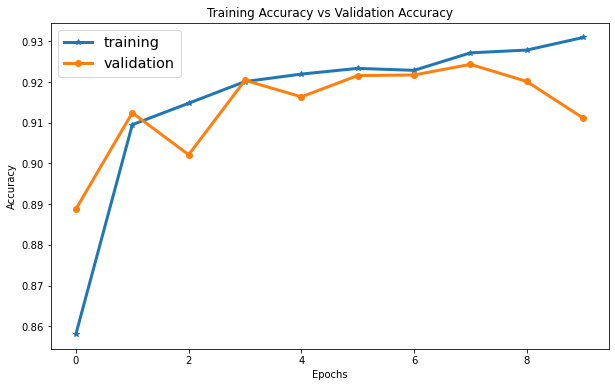

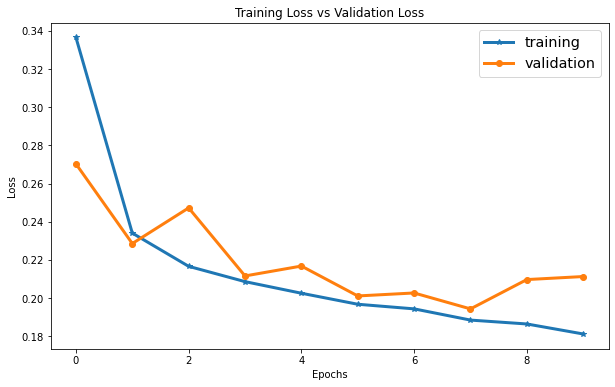

In [25]:
def visualize_training(vgg_history, lw = 3):
    plt.figure(figsize=(10,6))
    plt.plot(vgg_history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(vgg_history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize = 'x-large')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(vgg_history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(vgg_history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.show()
visualize_training(vgg_history)

# VGG-19 predictions

In [26]:
label = valid_generator.classes
pred= vgg_model.predict(valid_generator)

predicted_class_indices=np.argmax(pred,axis=1)

labels = (valid_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
vgg_predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print (labels)
print (vgg_predictions)

[0 0 0 ... 0 0 0]
{'Parasitized': 0, 'Uninfected': 1}
['Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 

In [27]:
image_path = '../input/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'
image = tf.keras.preprocessing.image.load_img(image_path)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
preds1 = vgg_model.predict_classes(input_arr)


In [28]:
preds1

array([[0]], dtype=int32)

In [29]:
rc = roc_curve(predicted_class_indices,label)
cf_matrix = confusion_matrix(predicted_class_indices,label)
cf_report = classification_report(predicted_class_indices,label)
print('Confusion matrix report of the model : \n{}'.format(cf_matrix))

Confusion matrix report of the model : 
[[3444 3444]
 [   0    0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
print('Classification report of the VGG19 model : \n{}'.format(cf_report))

Classification report of the VGG19 model : 
              precision    recall  f1-score   support

           0       1.00      0.50      0.67      6888
           1       0.00      0.00      0.00         0

    accuracy                           0.50      6888
   macro avg       0.50      0.25      0.33      6888
weighted avg       1.00      0.50      0.67      6888



In [31]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted,0,All
Actual,,
0,3444,3444
1,3444,3444
All,6888,6888
